# COVID-19 Literature Clustering

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
!pip install Bio
import Bio
from Bio import Entrez
from Bio import Medline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

#### specification du nombre de fichiers a lire : 

In [5]:
max_searchs = 50000
term = "coronavirus"


In [6]:
Entrez.email = 'A.N.Other@example.com'
ids=[[]]
for i in range(0,max_searchs,100):

  h = Entrez.esearch(db='pubmed', retmax=100,retstart=i, term=term)
  result = Entrez.read(h)
  ids.append(result['IdList'])
h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
records = Medline.parse(h)

KeyboardInterrupt: 

In [8]:
print(len(ids))

34


In [ ]:
records

In [ ]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
def append_records(records):
  dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
  for idx, entry in enumerate(records):

      if idx >100000:
          break
      try:
          dict_['paper_id'].append(entry["PMID"])
      except Exception as e:
          dict_['paper_id'].append("")
          
      try:
          dict_['abstract'].append(entry["AB"])
          # also create a column for the summary of abstract to be used in a plot
          if len(entry["AB"]) == 0: 
              # no abstract provided
              dict_['abstract_summary'].append("Not provided.")
          elif len(entry["AB"].split(' ')) > 100:
              # abstract provided is too long for plot, take first 100 words append with ...
              info = entry["AB"].split(' ')[:100]
              summary = get_breaks(' '.join(info), 40)
              dict_['abstract_summary'].append(summary + "...")
          else:
              # abstract is short enough
              summary = get_breaks(entry["AB"], 40)
              dict_['abstract_summary'].append(summary)
      except Exception as e:
          dict_['abstract'].append("")  
          dict_['abstract_summary'].append("Not provided.")

          
      try:
          dict_['body_text'].append(entry["AB"])
      except Exception as e:
          dict_['body_text'].append("")     
      
    
      
      
      try:
          # if more than one author
          authors = entry['AU'][0].split(',')
          if len(authors) > 2:
              # if more than 2 authors, take them all with html tag breaks in between
              dict_['authors'].append(get_breaks('. '.join(authors), 40))
          else:
              # authors will fit in plot
              dict_['authors'].append(". ".join(authors))
      except Exception as e:
          # if only one author - or Null valie
          try : 
              dict_['authors'].append(entry['AU'][0])
          except Exception as e:
              dict_['authors'].append("")


      
      # add the title information, add breaks when needed
      try:
          title = get_breaks(entry['TI'][0], 40)
          dict_['title'].append(title)
      # if title was not provided
      except Exception as e:
          try:
              dict_['title'].append(entry['TI'][0])
          except Exception as e:
              dict_['title'].append("")
      
      # add the journal information
      dict_['journal'].append(entry['PT'][0])


  return dict_

In [ ]:
dict_1 = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for i in range(1,len(ids)):
  h = Entrez.efetch(db='pubmed', id=ids[i], rettype='medline', retmode='json')
  records = Medline.parse(h)

  token = append_records(records)
  dict_1["paper_id"] = dict_1["paper_id"]+token["paper_id"]
  dict_1["abstract"] = dict_1["abstract"] + token["abstract"]
  dict_1["body_text"] =  dict_1["body_text"] +token["body_text"]
  dict_1["authors"] = dict_1["authors"] + token["authors"]
  dict_1["title"] =dict_1["title"] + token["title"]
  dict_1["journal"] =dict_1["journal"] +token["journal"]
  dict_1["abstract_summary"]=dict_1["abstract_summary"]+token["abstract_summary"]

In [ ]:
df_covid = pd.DataFrame(dict_1, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.info()

In [ ]:
df_covid.info()

## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [ ]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

In [ ]:
df_covid.info()

In [ ]:
df_covid['abstract'].describe(include='all')

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [15]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count                                                 71247
unique                                                71247
top       The recently emerged novel coronavirus pneumon...
freq                                                      1
Name: abstract, dtype: object

In [16]:
df_covid['body_text'].describe(include='all')

count                                                 71247
unique                                                71247
top       The recently emerged novel coronavirus pneumon...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [17]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,33979833,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,Finkel Y,S,Journal Article,Severe acute respiratory syndrome<br>coronavi...,199,199,125
1,33979817,GENERAL PURPOSE: To introduce the 15 recommend...,GENERAL PURPOSE: To introduce the 15 recommend...,Chabal LO,P,Journal Article,GENERAL PURPOSE: To introduce the 15<br>recom...,116,116,85
2,33979791,Segmenting lesion regions of Coronavirus Disea...,Segmenting lesion regions of Coronavirus Disea...,Ma Y,S,Journal Article,Segmenting lesion regions of Coronavirus<br>D...,185,185,133
3,33979779,BACKGROUND: To suppress the transmission of co...,BACKGROUND: To suppress the transmission of co...,O'Kane SM,C,Journal Article,BACKGROUND: To suppress the transmission of<b...,199,199,130
4,33979771,The effect of coronavirus disease (COVID-19) o...,The effect of coronavirus disease (COVID-19) o...,Barzegar M,C,Journal Article,The effect of coronavirus disease (COVID-19)<...,99,99,78


In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [18]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,71247.000000,71247.000000,71247.000000
mean,207.187545,207.187545,134.080270
std,89.188360,89.188360,47.336653
min,0.000000,0.000000,0.000000
25%,149.000000,149.000000,104.000000
50%,205.000000,205.000000,135.000000
75%,254.000000,254.000000,162.000000
max,1899.000000,1899.000000,894.000000


# Data Pre-processing

### Réduction de la taille du dataset :

In [19]:

#df = df_covid.sample(4000, random_state=42)
df = df_covid

### Suppression des valeurs null :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [20]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71247 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             71247 non-null  object
 1   abstract             71247 non-null  object
 2   body_text            71247 non-null  object
 3   authors              71247 non-null  object
 4   title                71247 non-null  object
 5   journal              71247 non-null  object
 6   abstract_summary     71247 non-null  object
 7   abstract_word_count  71247 non-null  int64 
 8   body_word_count      71247 non-null  int64 
 9   body_unique_words    71247 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 6.0+ MB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [21]:
!pip install tqdm
import tqdm
!pip install langdetect
import langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

     |████████████████████████████████| 983kB 4.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993223 sha256=e76fbbf263436032c35505e33be2470ec44955bea66657e6b293bfa520ac34c6
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


100%|██████████| 71247/71247 [06:49<00:00, 173.92it/s]


In [56]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 71247

{'ca': 5,
 'da': 1,
 'de': 5,
 'en': 71179,
 'es': 16,
 'fr': 11,
 'hu': 17,
 'id': 2,
 'it': 6,
 'no': 1,
 'ro': 1,
 'unknown': 2,
 'vi': 1}


Lets take a look at the language distribution in the dataset

'en'

In [60]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

ValueError: ignored


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [63]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71179 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   paper_id                  71179 non-null  object
 1   abstract                  71179 non-null  object
 2   body_text                 71179 non-null  object
 3   authors                   71179 non-null  object
 4   title                     71179 non-null  object
 5   journal                   71179 non-null  object
 6   abstract_summary          71179 non-null  object
 7   abstract_word_count       71179 non-null  int64 
 8   body_word_count           71179 non-null  int64 
 9   body_unique_words         71179 non-null  int64 
 10  language                  71179 non-null  object
 11  processed_text            71179 non-null  object
 12  text_wo_stopfreq          71179 non-null  object
 13  text_lemmatized           71179 non-null  object
 14  text_lemmatized_no_url

In [64]:
#Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [65]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [66]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [67]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
print(stopwords)
print("-----------")

print(punctuations)

['hence', 'someone', 'some', 'go', '’m', 'must', 'a', 'anything', 'to', 'me', 'keep', 'give', 'whatever', 'cannot', 'under', 'all', 'she', 'its', 'them', 'not', 'into', 'quite', 'bottom', 'ours', 'using', 'many', 'whose', 'at', 'ca', "'re", 'somehow', 'in', '‘s', '‘ll', "n't", 'over', 'any', 'him', '’d', 'often', 'sometimes', 'seems', 'sometime', 'used', 'after', 'perhaps', 'sixty', 'whereupon', 'he', 'there', 'however', 'side', 'across', 'during', 'move', 'here', 'indeed', 'least', 'other', 'anyhow', 'should', 'although', 'elsewhere', 're', '‘re', 'had', 'itself', 'thereupon', '’ll', 'another', 'where', 'my', 'twenty', 'wherein', 'still', 'anywhere', 'have', 'please', 'why', 'none', 'two', 'whether', 'does', 'something', 'therefore', 'done', 'most', 'others', 'when', 'nor', 'everywhere', 'whither', 'per', 'thus', 'did', 'off', 'nevertheless', 'forty', 'various', 'call', 'am', 'regarding', 'through', 'n‘t', 'from', 'more', 'do', 'until', 'next', 'or', 'via', 'beyond', 'so', 'are', 'eve

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [69]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [70]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)

    mytokens = [ word for word in mytokens if word not in stopwords and word.text not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [71]:
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#c'est dans cette partie la que ça bug , ça prend un temps énorme et on a pas eu de résultat  
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#tqdm.pandas()
#df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

In [72]:
import spacy
nlp = en_core_web_lg.load()
def spacy_process(texte):
    tmp = []
    tmp.append(texte)
    for lt in tmp:
        mytokens = nlp(lt)
        mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text not in stopwords]
        mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].apply(spacy_process)

### Exemple

In [73]:
test1 = spacy_process("vaccinations")
test2 = spacy_process("vaccination")
test3 = spacy_process("vaccinating")
test4 = spacy_process("vaccinated")
print(test1)
print(test2)
print(test3)
print(test4)

vaccination
vaccination
vaccinate
vaccinate


In [74]:
df.head()


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html
0,33979833,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,Finkel Y,S,Journal Article,Severe acute respiratory syndrome<br>coronavi...,199,199,125,en,severe acute respiratory syndrome coronavirus ...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...
1,33979817,GENERAL PURPOSE: To introduce the 15 recommend...,GENERAL PURPOSE: To introduce the 15 recommend...,Chabal LO,P,Journal Article,GENERAL PURPOSE: To introduce the 15<br>recom...,116,116,85,en,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...
2,33979791,Segmenting lesion regions of Coronavirus Disea...,Segmenting lesion regions of Coronavirus Disea...,Ma Y,S,Journal Article,Segmenting lesion regions of Coronavirus<br>D...,185,185,133,en,segment lesion region coronavirus disease 2019...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...
3,33979779,BACKGROUND: To suppress the transmission of co...,BACKGROUND: To suppress the transmission of co...,O'Kane SM,C,Journal Article,BACKGROUND: To suppress the transmission of<b...,199,199,130,en,background to suppress transmission coronaviru...,background to suppress transmission government...,background to suppress transmission government...,background to suppress transmission government...,background to suppress transmission government...
4,33979771,The effect of coronavirus disease (COVID-19) o...,The effect of coronavirus disease (COVID-19) o...,Barzegar M,C,Journal Article,The effect of coronavirus disease (COVID-19)<...,99,99,78,en,the effect coronavirus disease covid-19 risk r...,effect relapse multiple sclerosis ms unknown r...,effect relapse multiple sclerosis m unknown re...,effect relapse multiple sclerosis m unknown re...,effect relapse multiple sclerosis m unknown re...


In [75]:
nlp = en_core_web_lg.load()

tmp = "The COVID-19 pandemic poses new challenges"
for lt in tmp:
    mytokens = nlp(lt)
    mytokens2 = [word.lemma_.lower().strip() for word in mytokens]
    mytokens2 = " ".join([i for i in mytokens2])
    print(mytokens2)


t
h
e

c
o
v
i
d
-
1
9

p
a
n
d
e
m
i
c

p
o
s
e
s

n
e
w

c
h
a
l
l
e
n
g
e
s


In [77]:
processed_text = df["processed_text"]
body_text = df["body_text"]

for i in range(1,10):
    print(body_text[i])
    print("")
    print(processed_text[i])
    print("")
    print("----------------------------------------------------------")



GENERAL PURPOSE: To introduce the 15 recommendations of the International Ostomy Guideline (IOG) 2020, covering the four key arenas of education, holistic aspects, and pre- and postoperative care; and to summarize key concepts for clinicians to customize for translation into their practice. TARGET AUDIENCE: This continuing education activity is intended for physicians, physician assistants, nurse practitioners, and nurses with an interest in skin and wound care. LEARNING OBJECTIVES/OUTCOMES: After participating in this educational activity, the participant will:1. Analyze supporting evidence for the education recommendations in the IOG 2020.2. Identify a benefit of the International Charter of Ostomate Rights.3. Distinguish concepts related to pre- and postoperative ostomy-related care.4. Select a potential barrier to IOG 2020 guideline implementation.

general purpose to introduce 15 recommendation international ostomy guideline iog 2020 cover key arena education holistic aspect pre- 

### Removal of Frequent words
So this step is to remove the frequent words in the given corpus. If we use something like tfidf, this is automatically taken care of.

In [37]:
from collections import Counter
cnt = Counter()
for text in df["processed_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(40)

[('covid-19', 184585),
 ('patient', 133398),
 ('%', 124652),
 ('the', 114428),
 ('sars', 80807),
 ('disease', 73047),
 ('-', 72985),
 ('cov-2', 66397),
 ('coronavirus', 65931),
 ('study', 63510),
 ('pandemic', 57625),
 ('infection', 55742),
 ('result', 48282),
 ('health', 47434),
 ('case', 43246),
 ('virus', 41284),
 ('respiratory', 40928),
 ('high', 40597),
 ('severe', 39209),
 ('we', 38410),
 ('in', 36998),
 ('clinical', 35747),
 ('2019', 34957),
 ('risk', 33566),
 ('include', 33119),
 ('care', 32170),
 ('2020', 29918),
 ('this', 29180),
 ('method', 29076),
 ('report', 28970),
 ('acute', 28536),
 ('/', 27835),
 ('=', 27393),
 ('2', 27364),
 ('treatment', 26340),
 ('increase', 26316),
 ('datum', 26228),
 ('syndrome', 25728),
 ('a', 25009),
 ('cell', 24766)]

In [38]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(30)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["processed_text"].apply(lambda text: remove_freqwords(text))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
df["body_text"]

0        Severe acute respiratory syndrome coronavirus ...
1        GENERAL PURPOSE: To introduce the 15 recommend...
2        Segmenting lesion regions of Coronavirus Disea...
3        BACKGROUND: To suppress the transmission of co...
4        The effect of coronavirus disease (COVID-19) o...
                               ...                        
99995    From the mid-1960s onwards, it was believed th...
99996    Mouse hepatitis virus (MHV) causes encephaliti...
99997    BACKGROUND: In March of 2003, an outbreak of S...
99998    The severe acute respiratory syndrome coronavi...
99999    Both the threat of bioterrorism and the natura...
Name: body_text, Length: 71179, dtype: object

In [40]:
df["text_wo_stopfreq"]

0        acute syndrome 2 cause ongoing 19 pandemic(1 c...
1        general purpose to introduce 15 recommendation...
2        segment lesion region compute tomography ct im...
3        background to suppress transmission government...
4        effect relapse multiple sclerosis ms unknown r...
                               ...                        
99995    from mid-1960 onwards believe human specie inf...
99996    mouse hepatitis mhv cause encephalitis demyeli...
99997    background march 2003 outbreak acute syndrome ...
99998    acute syndrome cov nucleocapsid protein np pre...
99999    both threat bioterrorism natural emergence con...
Name: text_wo_stopfreq, Length: 71179, dtype: object

In [41]:
df["processed_text"]

0        severe acute respiratory syndrome coronavirus ...
1        general purpose to introduce 15 recommendation...
2        segment lesion region coronavirus disease 2019...
3        background to suppress transmission coronaviru...
4        the effect coronavirus disease covid-19 risk r...
                               ...                        
99995    from mid-1960 onwards believe human coronaviru...
99996    mouse hepatitis virus mhv cause encephalitis d...
99997    background in march 2003 outbreak severe acute...
99998    the severe acute respiratory syndrome coronavi...
99999    both threat bioterrorism natural emergence con...
Name: processed_text, Length: 71179, dtype: object

### Removal of Rare words
This is very similar to previous preprocessing step but we will remove the rare words from the corpus.

In [42]:
#cnt.most_common()[:-500-1:-1]

In [43]:
# n_rare_words = 10
# RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
# def remove_rarewords(text):
#     """custom function to remove the rare words"""
#     return " ".join([word for word in str(text).split() if word not in RAREWORDS])

# df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
# df.head()

### Lemmatization

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

In [44]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Now let us redo the lemmatization process for our dataset.

In [45]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [46]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [47]:
df.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized
0,33979833,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,Finkel Y,S,Journal Article,Severe acute respiratory syndrome<br>coronavi...,199,199,125,en,severe acute respiratory syndrome coronavirus ...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...
1,33979817,GENERAL PURPOSE: To introduce the 15 recommend...,GENERAL PURPOSE: To introduce the 15 recommend...,Chabal LO,P,Journal Article,GENERAL PURPOSE: To introduce the 15<br>recom...,116,116,85,en,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...
2,33979791,Segmenting lesion regions of Coronavirus Disea...,Segmenting lesion regions of Coronavirus Disea...,Ma Y,S,Journal Article,Segmenting lesion regions of Coronavirus<br>D...,185,185,133,en,segment lesion region coronavirus disease 2019...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...
3,33979779,BACKGROUND: To suppress the transmission of co...,BACKGROUND: To suppress the transmission of co...,O'Kane SM,C,Journal Article,BACKGROUND: To suppress the transmission of<b...,199,199,130,en,background to suppress transmission coronaviru...,background to suppress transmission government...,background to suppress transmission government...
4,33979771,The effect of coronavirus disease (COVID-19) o...,The effect of coronavirus disease (COVID-19) o...,Barzegar M,C,Journal Article,The effect of coronavirus disease (COVID-19)<...,99,99,78,en,the effect coronavirus disease covid-19 risk r...,effect relapse multiple sclerosis ms unknown r...,effect relapse multiple sclerosis m unknown re...


In [48]:
processed_text = df["processed_text"]
body_text = df["body_text"]
text_lemmatized = df["text_lemmatized"]

for i in range(1,10):
    print(body_text[i])
    print("")
    print(processed_text[i])
    print("")
    print(text_lemmatized[i])
    print("----------------------------------------------------------")



GENERAL PURPOSE: To introduce the 15 recommendations of the International Ostomy Guideline (IOG) 2020, covering the four key arenas of education, holistic aspects, and pre- and postoperative care; and to summarize key concepts for clinicians to customize for translation into their practice. TARGET AUDIENCE: This continuing education activity is intended for physicians, physician assistants, nurse practitioners, and nurses with an interest in skin and wound care. LEARNING OBJECTIVES/OUTCOMES: After participating in this educational activity, the participant will:1. Analyze supporting evidence for the education recommendations in the IOG 2020.2. Identify a benefit of the International Charter of Ostomate Rights.3. Distinguish concepts related to pre- and postoperative ostomy-related care.4. Select a potential barrier to IOG 2020 guideline implementation.

general purpose to introduce 15 recommendation international ostomy guideline iog 2020 cover key arena education holistic aspect pre- 

### Removal of URLs

In [49]:
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [50]:
df["text_lemmatized_no_url"] = df["text_lemmatized"].apply(lambda text: remove_urls(text))
df.head()
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url
0,33979833,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,Finkel Y,S,Journal Article,Severe acute respiratory syndrome<br>coronavi...,199,199,125,en,severe acute respiratory syndrome coronavirus ...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...
1,33979817,GENERAL PURPOSE: To introduce the 15 recommend...,GENERAL PURPOSE: To introduce the 15 recommend...,Chabal LO,P,Journal Article,GENERAL PURPOSE: To introduce the 15<br>recom...,116,116,85,en,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...
2,33979791,Segmenting lesion regions of Coronavirus Disea...,Segmenting lesion regions of Coronavirus Disea...,Ma Y,S,Journal Article,Segmenting lesion regions of Coronavirus<br>D...,185,185,133,en,segment lesion region coronavirus disease 2019...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...
3,33979779,BACKGROUND: To suppress the transmission of co...,BACKGROUND: To suppress the transmission of co...,O'Kane SM,C,Journal Article,BACKGROUND: To suppress the transmission of<b...,199,199,130,en,background to suppress transmission coronaviru...,background to suppress transmission government...,background to suppress transmission government...,background to suppress transmission government...
4,33979771,The effect of coronavirus disease (COVID-19) o...,The effect of coronavirus disease (COVID-19) o...,Barzegar M,C,Journal Article,The effect of coronavirus disease (COVID-19)<...,99,99,78,en,the effect coronavirus disease covid-19 risk r...,effect relapse multiple sclerosis ms unknown r...,effect relapse multiple sclerosis m unknown re...,effect relapse multiple sclerosis m unknown re...


### Removal of HTML Tags

In [51]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [52]:
df["text_lemmatized_url_html"] = df["text_lemmatized_no_url"].apply(lambda text: remove_html(text))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html
0,33979833,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,Finkel Y,S,Journal Article,Severe acute respiratory syndrome<br>coronavi...,199,199,125,en,severe acute respiratory syndrome coronavirus ...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...,acute syndrome 2 cause ongoing 19 pandemic(1 c...
1,33979817,GENERAL PURPOSE: To introduce the 15 recommend...,GENERAL PURPOSE: To introduce the 15 recommend...,Chabal LO,P,Journal Article,GENERAL PURPOSE: To introduce the 15<br>recom...,116,116,85,en,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...,general purpose to introduce 15 recommendation...
2,33979791,Segmenting lesion regions of Coronavirus Disea...,Segmenting lesion regions of Coronavirus Disea...,Ma Y,S,Journal Article,Segmenting lesion regions of Coronavirus<br>D...,185,185,133,en,segment lesion region coronavirus disease 2019...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...,segment lesion region compute tomography ct im...
3,33979779,BACKGROUND: To suppress the transmission of co...,BACKGROUND: To suppress the transmission of co...,O'Kane SM,C,Journal Article,BACKGROUND: To suppress the transmission of<b...,199,199,130,en,background to suppress transmission coronaviru...,background to suppress transmission government...,background to suppress transmission government...,background to suppress transmission government...,background to suppress transmission government...
4,33979771,The effect of coronavirus disease (COVID-19) o...,The effect of coronavirus disease (COVID-19) o...,Barzegar M,C,Journal Article,The effect of coronavirus disease (COVID-19)<...,99,99,78,en,the effect coronavirus disease covid-19 risk r...,effect relapse multiple sclerosis ms unknown r...,effect relapse multiple sclerosis m unknown re...,effect relapse multiple sclerosis m unknown re...,effect relapse multiple sclerosis m unknown re...


### Let's take a look at word count in the papers

In [53]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    71179.000000
mean       207.227455
std         89.059328
min          0.000000
25%        149.000000
50%        205.000000
75%        254.000000
max       1899.000000
Name: body_word_count, dtype: float64

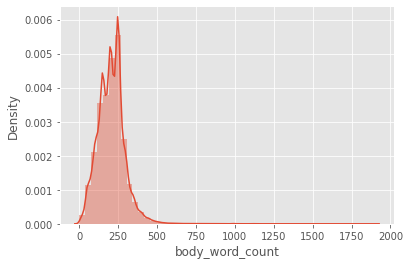

In [54]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    71179.000000
mean       134.100788
std         47.220880
min          0.000000
25%        104.000000
50%        135.000000
75%        162.000000
max        894.000000
Name: body_unique_words, dtype: float64

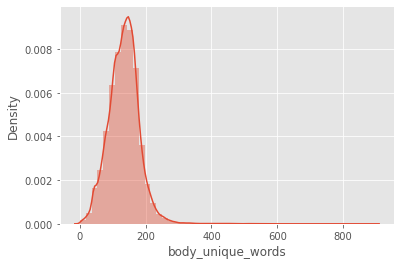

In [55]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [ ]:
text = df['text_lemmatized_url_html'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text, 2 ** 12)
X.shape
print(X)

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [ ]:
from sklearn.cluster import KMeans

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred
df['y']

# Dimensionality Reduction with t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(5, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.


# NMF

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
nmf = NMF(n_components=20, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(30, 60), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
#vectorizer = TfidfVectorizer(max_features= 2 ** 12)


In [ ]:
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, 40,
               'Topics in NMF model')

In [ ]:
all_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [ ]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

# Word's Similarity

In [ ]:
! python3 -m spacy download en_core_web_md
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,words)
    print("")
    for token in doc:
        #print(token.text, token.has_vector, token.vector_norm, token.is_oov) 
        if cov_word.similarity(token) > 0.5 :
            print("Similarity Between {",cov_word,"} and {",token,"} is :   ",cov_word.similarity(token))
    print("__________________________________________________________________")


In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
top_similar = []
for num_clus in range(0,20):
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    for token in doc:
        if cov_word.similarity(token) > 0.5 :
            top_similar.append((token.text , cov_word.similarity(token)))
LL = top_similar
top_similar_sorted = []
for a in top_similar :
    if a not in top_similar_sorted:
        top_similar_sorted.append(a)
top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
top_similar_sorted

In [ ]:
li = top_similar_sorted[0:10]

In [ ]:
nlp = spacy.load('en_core_web_md')
lii = []
for tup in li:
    cov_word =nlp(tup[0])
    top_similar = []
    for num_clus in range(0,20):
        str1 = ' '.join(all_keywords[num_clus])
        doc = nlp(str1)
        words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
        for token in doc:
            if cov_word.similarity(token) > 0.5 :
                top_similar.append((token.text , cov_word.similarity(token)))
    top_similar_sorted = []
    for a in top_similar :
        if a not in top_similar_sorted:
            top_similar_sorted.append(a)
    top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
    top_similar_sorted = top_similar_sorted[0:10]
    lii.append((tup[0],top_similar_sorted))
# LL = top_similar
# top_similar_sorted = []
# for a in top_similar :
#     if a not in top_similar_sorted:
#         top_similar_sorted.append(a)
# top_similar_sorted = sorted(top_similar_sorted, key=lambda tup: tup[1],reverse=True)
# top_similar_sorted
top_ten_of_ten = lii
top_ten_of_ten

In [ ]:

ten_diseases = []
for i,mots in top_similar_sorted :
    if mots not in ten_diseases:
        ten_diseases.append(i)
ten_diseases

In [ ]:
hundred_diseases = []
for i,mots in top_ten_of_ten :
    for mot,val in mots:
        if mot not in hundred_diseases:
            hundred_diseases.append(mot)
hundred_diseases


In [ ]:
print(lemmatizer.lemmatize("diabete"))
print(lemmatizer.lemmatize("diabetes"))
print(lemmatizer.lemmatize("diabetic"))

print(lemmatizer.lemmatize("feet"))

print(lemmatizer.lemmatize("vaccinations"))
print(lemmatizer.lemmatize("vaccination"))
print(lemmatizer.lemmatize("vaccinated"))

print(lemmatizer.lemmatize("speaking"))
print(lemmatizer.lemmatize("speaks"))
print(lemmatizer.lemmatize("spoken"))



# LDA

In [ ]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
tff = tf.fit_transform(text)
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', random_state=42)
lda.fit(tff)


In [ ]:
tf_feature_names = tf.get_feature_names()
plot_top_words(lda, tf_feature_names, 40, 'Topics in LDA model')

In [ ]:
all_keywords = []
for topic_idx, topic in enumerate(lda.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-100 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [ ]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST)
    print("")

# LSA

In [ ]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [ ]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0] ," ",end='')
    print(" ")

In [ ]:
all_keywords = []
for topic_idx, topic in enumerate(svd_model.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)


In [ ]:
for num_clus in range(0,19):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First we will create 20 vectorizers, one for each of our cluster labels

In [ ]:
vectorizers = []
    
for ii in range(0, 5):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

Now we will vectorize the data from each of our clusters

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'text_lemmatized_url_html']))
        #d'ou vient df['y'] =   y_pred = kmeans.fit_predict(X_reduced)      df['y'] = y_pred       df['y']
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
len(vectorized_data)

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

# Topic modeling on each cluster using LDA : 

In [ ]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

lda_models = []
for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [ ]:
for i in range(0,5):
    print(all_keywords[i])

In [ ]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

# Topic modeling on each cluster using NMF : 

In [ ]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

nmf_models = []
for ii in range(0, 5):
    # nmf
    nmf = NMF(n_components=NUM_TOPICS_PER_CLUSTER, random_state=1,alpha=.1, l1_ratio=.5)
    nmf_models.append(nmf)
    
nmf_models[0]

In [ ]:
clusters_nmf_data = []

for current_cluster, nmf in enumerate(nmf_models):
    print("Current Cluster: " + str(current_cluster))
    if vectorized_data[current_cluster] != None:
        clusters_nmf_data.append((nmf.fit_transform(vectorized_data[current_cluster])))

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
all_keywords = []
for current_vectorizer, nmf in enumerate(nmf_models):
    # print("Current Cluster: " + str(current_vectorizer))
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(nmf, vectorizers[current_vectorizer]))

In [ ]:
for i in range(0,5):
    print(all_keywords[i])

## travail realisé :
 - detection automatique des noms de maladies
 - construction d'un corpus en utilisant les noms des maladies detectés

In [ ]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")


In [ ]:
from Bio import Entrez
from Bio import Medline
import json


MAX_COUNT = 3
for TERM in ten_diseases:
    Entrez.email = 'A.N.Other@example.com'
    h = Entrez.esearch(db='pubmed', retmax=MAX_COUNT, term=TERM)
    result = Entrez.read(h)
    ids = result['IdList']
    h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
    records = Medline.parse(h)
    i=0
    for record in records:
        filename="fichier_"+TERM+str(i)+".json"
        json.dump(record, open(".\\new_corpus\\"+filename, 'w'))
        data = json.load(open(".\\new_corpus\\"+filename))
        i=i+1
[(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]

In [ ]:
len(all_keywords)